In [1]:
import os
os.chdir("../")

from data_management.DataManager import CALFData, collateGCN
import numpy as np
import torch 
from Model import ContextAwareModel
from helpers.loss import ContextAwareLoss, SpottingLoss
from modules.train import trainer
import pickle
from dataclasses import dataclass
import matplotlib.pyplot as plt
from modules.Visualiser import collateVisGCN, Visualiser
import seaborn as sns
from helpers.classes import EVENT_DICTIONARY_V2_ALIVE as event_enc
from helpers.classes import get_K_params


In [2]:
@dataclass
class Args:
    receptive_field = 6
    fps = 5
    chunks_per_epoch = 1824
    class_split = "alive"
    chunk_size = 30
    batch_size = 32
    input_channel = 13
    feature_multiplier=1
    backbone_player = "GCN"
    max_epochs=180
    load_weights=None
    model_name="Testing_Model"
    dim_capsule=16
    lambda_coord=5.0
    lambda_noobj=0.5
    patience=25
    LR=1e-03
    GPU=0 
    max_num_worker=1
    loglevel='INFO'
    annotation_nr = 10
    K_parameters = get_K_params(chunk_size)
    focused_annotation = None
    generate_augmented_data = True
    sgementation_path = None
    freeze_model = True
    generate_artificial_targets = False

# Grid Search Train 

In [3]:
args = Args
collate_fn = collateGCN

for i, chunk_size in enumerate(np.arange(10,70,10)):

    # Set manually parameters 
    receptive_field = 0.2 * chunk_size

    args.K_parameters = get_K_params(chunk_size)
    args.chunk_size = chunk_size
    args.receptive_field = receptive_field

    train_dataset = CALFData(split="train", args=args)
    validation_dataset = CALFData(split="validate", args=args)

    train_loader = torch.utils.data.DataLoader(train_dataset,
                batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

    validate_loader = torch.utils.data.DataLoader(validation_dataset,
                batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)
    
    model = ContextAwareModel(args=args)
    criterion = ContextAwareLoss(K=train_dataset.K_parameters)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=args.LR, 
                                betas=(0.9, 0.999), eps=1e-07, 
                                weight_decay=0, amsgrad=False)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=args.patience)

    losses = trainer(train_loader, validate_loader,
                        model, optimizer, scheduler, 
                        criterion,
                        model_name=args.model_name,
                        max_epochs=args.max_epochs, 
                        save_dir=f"models/gridsearch{i}.pth.tar")
    
    del train_dataset, validation_dataset, train_loader, validate_loader
    
    with open(f'results/gridsearch{i}_results.pkl', 'wb') as file:
        pickle.dump(losses, file)

Get labels & features: 100%|██████████| 8/8 [02:19<00:00, 17.50s/it]
Train 1: Time 0.878s (it:0.896s) Data:0.212s (it:0.176s) Loss 1.2699e+01 : 100%|████████████████████████████████████████████████| 57/57 [00:50<00:00,  1.14it/s]
Evaluate 1: Time 0.399s (it:0.410s) Data:0.108s (it:0.109s) Loss 1.6140e+01 : 100%|█████████████████████████████████████████████| 57/57 [00:22<00:00,  2.50it/s]
Train 2: Time 0.828s (it:0.790s) Data:0.162s (it:0.148s) Loss 1.1773e+01 : 100%|████████████████████████████████████████████████| 57/57 [00:47<00:00,  1.21it/s]
Evaluate 2: Time 0.417s (it:0.404s) Data:0.110s (it:0.108s) Loss 1.1313e+01 : 100%|█████████████████████████████████████████████| 57/57 [00:23<00:00,  2.40it/s]
Train 3: Time 0.935s (it:0.801s) Data:0.209s (it:0.147s) Loss 1.1030e+01 : 100%|████████████████████████████████████████████████| 57/57 [00:53<00:00,  1.07it/s]
Evaluate 3: Time 0.436s (it:0.459s) Data:0.112s (it:0.114s) Loss 9.5015e+00 : 100%|███████████████████████████████████████████

In [3]:
args = Args
collate_fn = collateVisGCN
precisions_combined = np.empty((0, args.annotation_nr+1))
recalls_combined = np.empty((0, args.annotation_nr+1))
f1_combined = np.empty((0, args.annotation_nr+1))

for i, chunk_size in enumerate(np.arange(10,70,10)):

    # Set manually parameters 
    receptive_field = 0.2 * chunk_size

    args.K_parameters = get_K_params(chunk_size)
    args.chunk_size = chunk_size
    args.receptive_field = receptive_field

    model_path = f"models/gridsearch{i}.pth.tar"
    model = torch.load(model_path)
    visualiser = Visualiser(collate_fn, args, model, smooth_rate=None, val=True)
    precision, recall, f1_score, _ = visualiser.norm_evaluation_segmentation()

    precision_expaned = np.expand_dims(np.concatenate((np.array([np.mean(precision)]),precision)), axis=0)
    precisions_combined = np.concatenate((precisions_combined, precision_expaned), axis=0)

    recall_expaned = np.expand_dims(np.concatenate((np.array([np.mean(recall)]),recall)), axis=0)
    recalls_combined = np.concatenate((recalls_combined, recall_expaned), axis=0)
    
    f1_expaned = np.expand_dims(np.concatenate((np.array([np.mean(f1_score)]),f1_score)), axis=0)
    f1_combined = np.concatenate((f1_combined, f1_expaned), axis=0)



Data preprocessing: 100%|██████████| 1/1 [00:08<00:00,  8.53s/it]


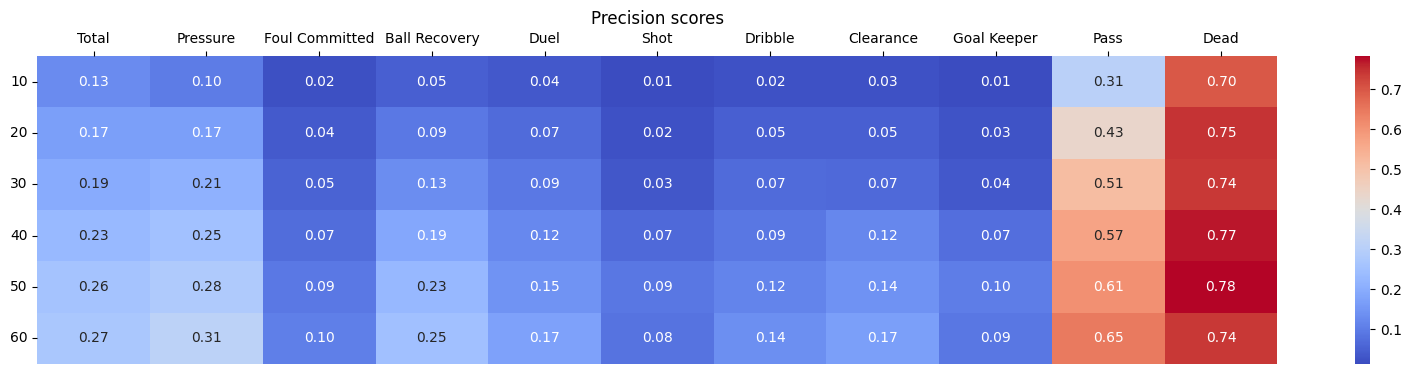

In [4]:
cols = ["Total"] + list(event_enc.keys())
rows = ["10", "20", "30", "40", "50", "60"]

plt.figure(figsize=(20, 4))
plt.title("Precision scores")
ax = sns.heatmap(precisions_combined, annot=True, cmap="coolwarm", fmt=".2f", xticklabels=True, yticklabels=True)

ax.set_xticklabels(cols, rotation=0)
ax.xaxis.tick_top()

ax.set_yticklabels(rows, rotation=0)

plt.show()

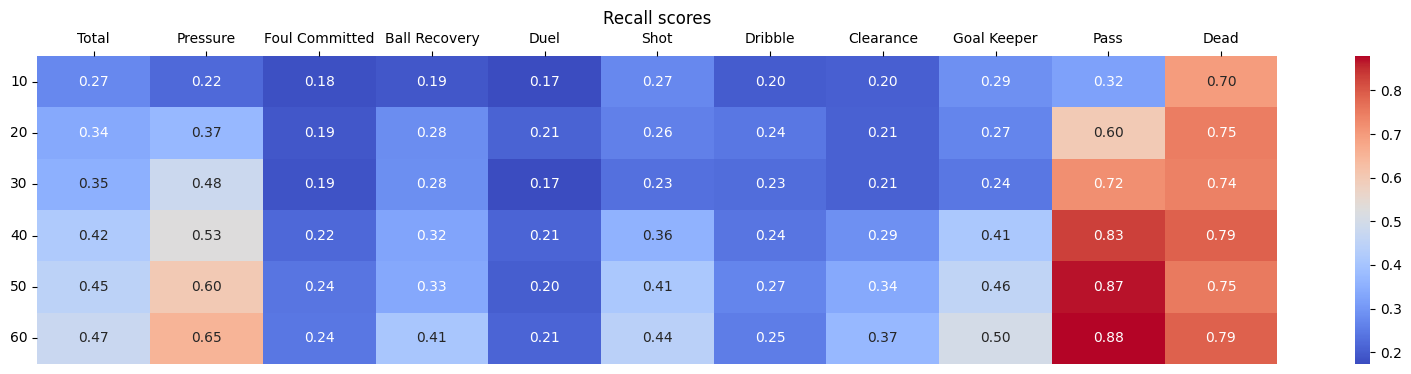

In [5]:
cols = ["Total"] + list(event_enc.keys())
rows = ["10", "20", "30", "40", "50", "60"]

plt.figure(figsize=(20, 4))
plt.title("Recall scores")
ax = sns.heatmap(recalls_combined, annot=True, cmap="coolwarm", fmt=".2f", xticklabels=True, yticklabels=True)

ax.set_xticklabels(cols, rotation=0)
ax.xaxis.tick_top()

ax.set_yticklabels(rows, rotation=0)

plt.show()

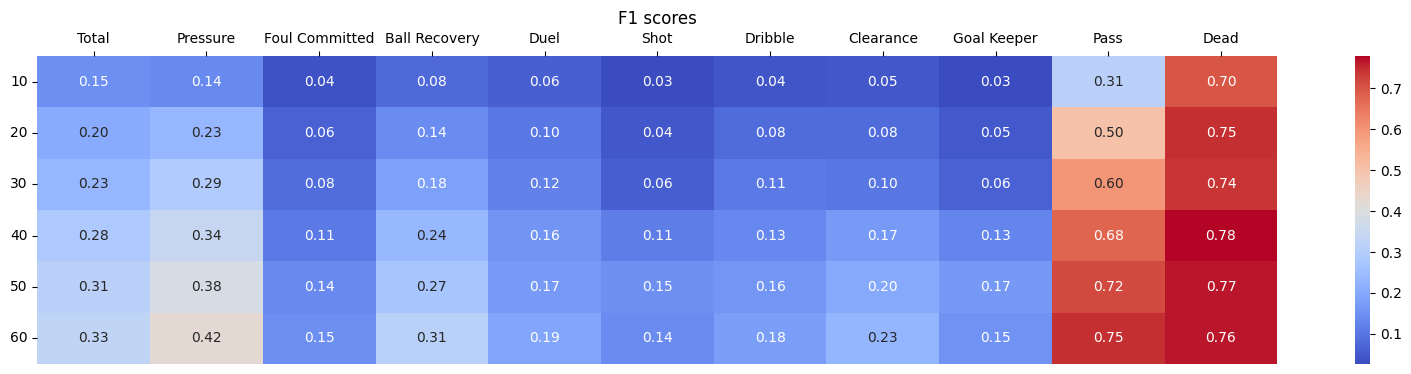

In [6]:
cols = ["Total"] + list(event_enc.keys())
rows = ["10", "20", "30", "40", "50", "60"]

plt.figure(figsize=(20, 4))
plt.title("F1 scores")
ax = sns.heatmap(f1_combined, annot=True, cmap="coolwarm", fmt=".2f", xticklabels=True, yticklabels=True)

ax.set_xticklabels(cols, rotation=0)
ax.xaxis.tick_top()

ax.set_yticklabels(rows, rotation=0)

plt.show()

Data preprocessing: 100%|██████████| 1/1 [00:08<00:00,  8.52s/it]


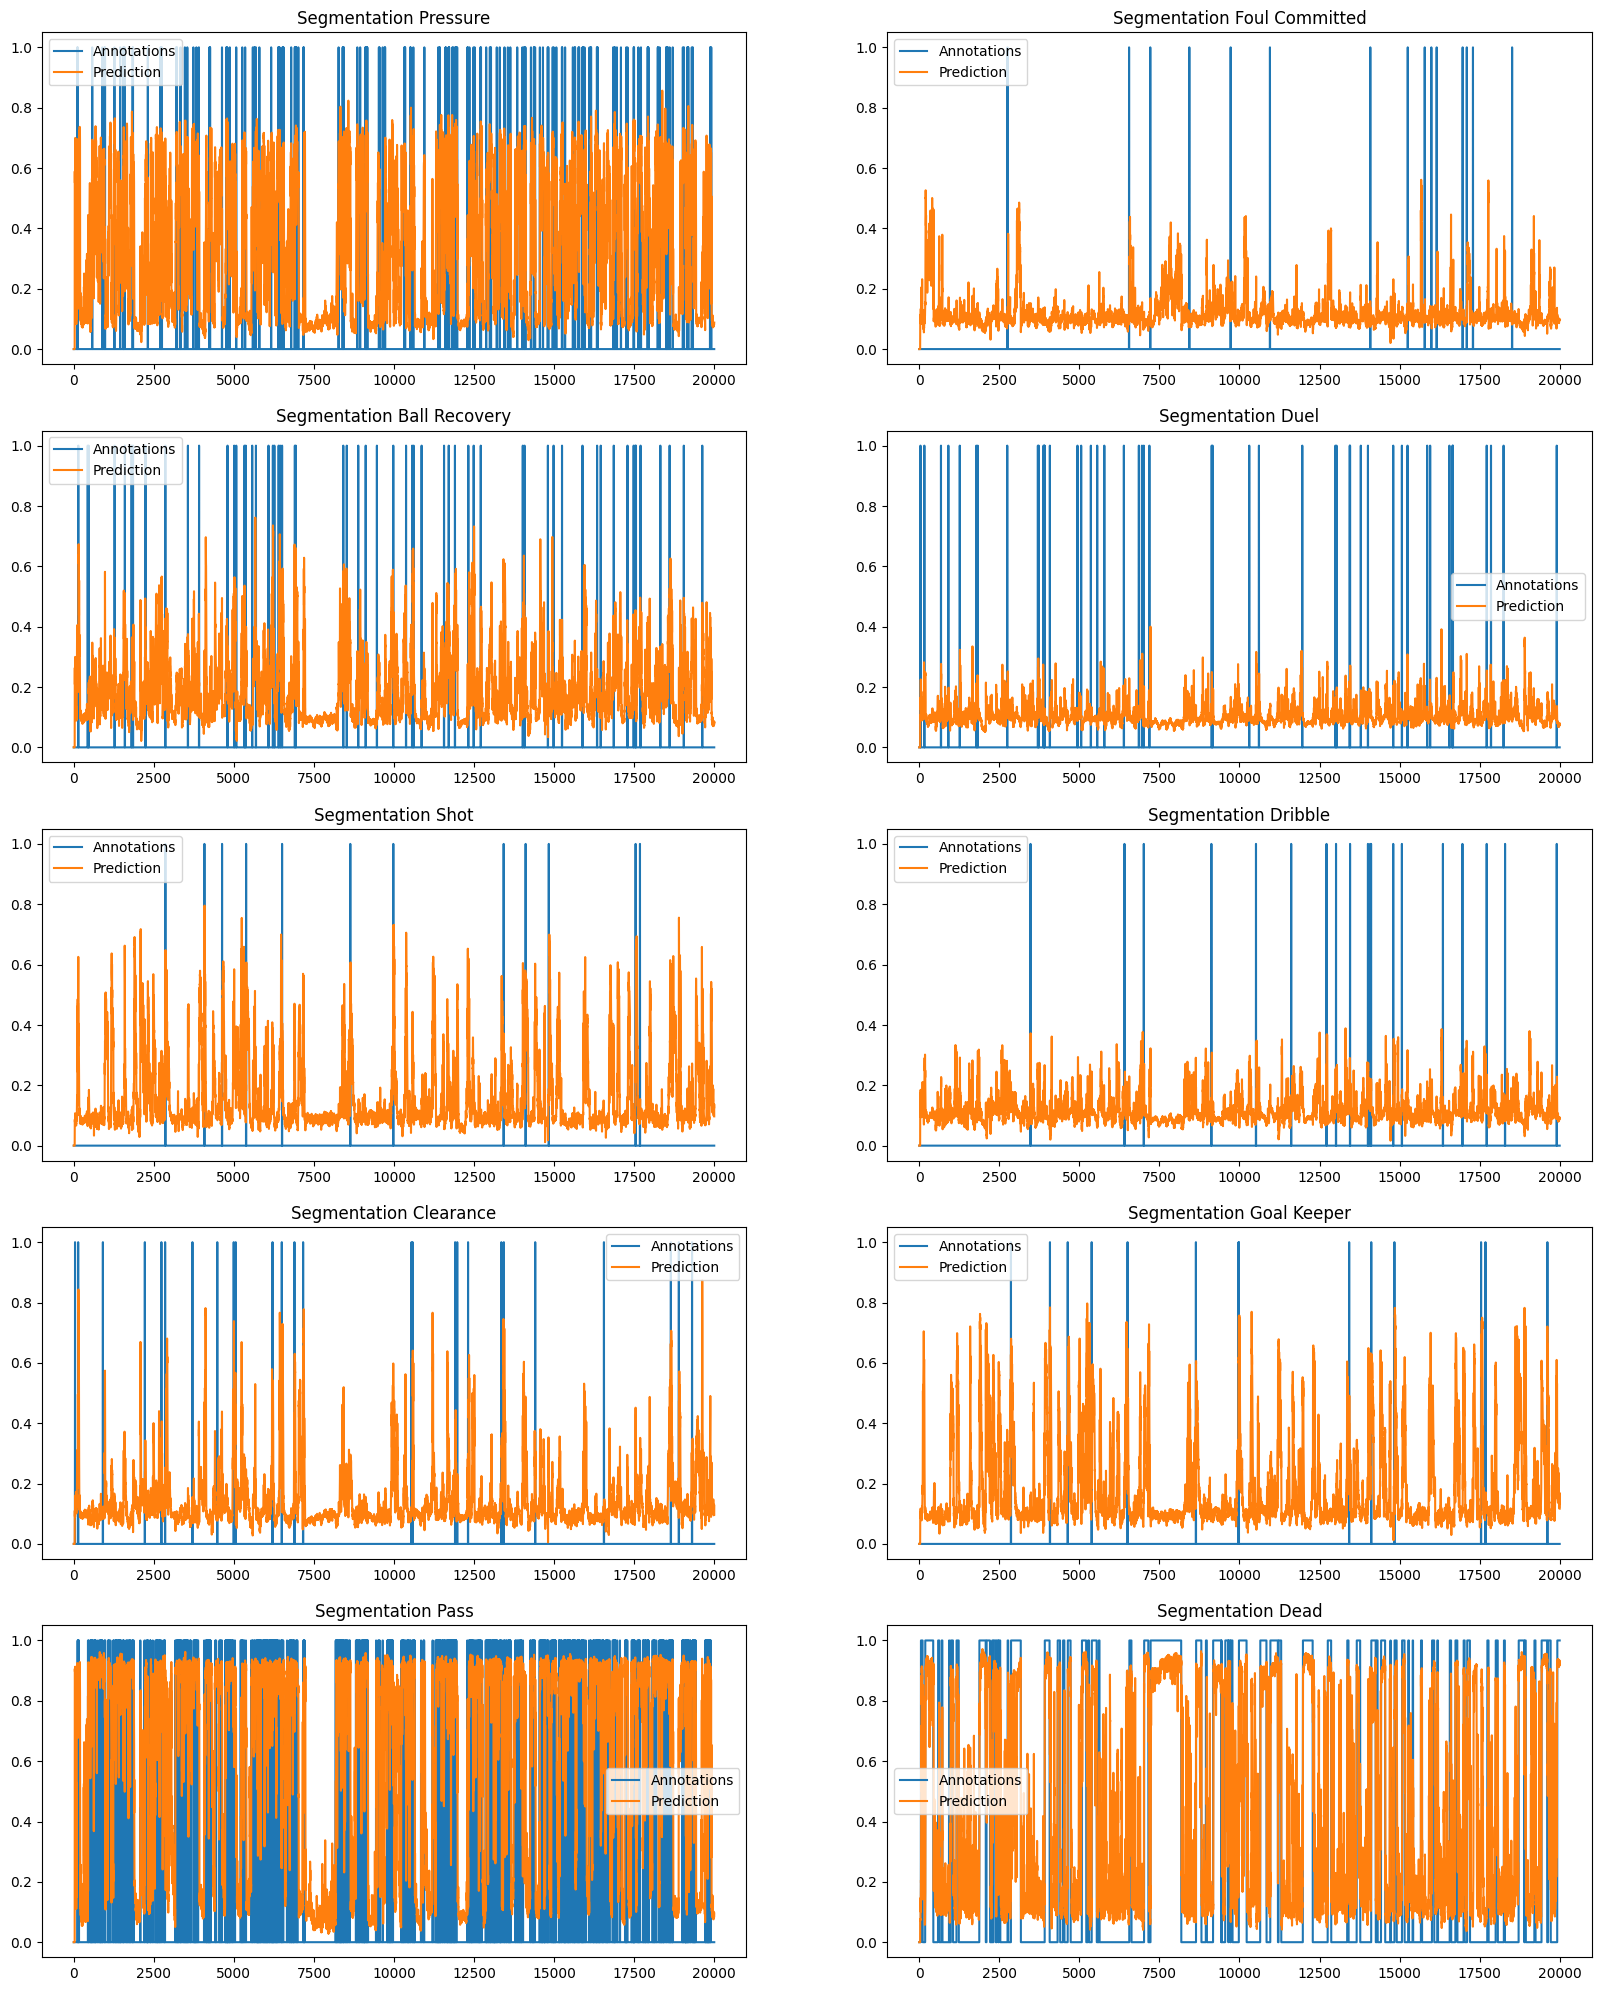

(<Figure size 2000x2500 with 10 Axes>,
 array([[<Axes: title={'center': 'Segmentation Pressure'}>,
         <Axes: title={'center': 'Segmentation Foul Committed'}>],
        [<Axes: title={'center': 'Segmentation Ball Recovery'}>,
         <Axes: title={'center': 'Segmentation Duel'}>],
        [<Axes: title={'center': 'Segmentation Shot'}>,
         <Axes: title={'center': 'Segmentation Dribble'}>],
        [<Axes: title={'center': 'Segmentation Clearance'}>,
         <Axes: title={'center': 'Segmentation Goal Keeper'}>],
        [<Axes: title={'center': 'Segmentation Pass'}>,
         <Axes: title={'center': 'Segmentation Dead'}>]], dtype=object))

In [21]:
chunk_size = 60
receptive_field = 0.2 * chunk_size
args.K_parameters = get_K_params(chunk_size)
args.chunk_size = chunk_size
args.receptive_field = receptive_field
collate_fn = collateVisGCN
model_path = f"models/gridsearch{5}.pth.tar"
model = torch.load(model_path)
visualiser = Visualiser(collate_fn, args, model, smooth_rate=None, val=True)
visualiser.plot_predictions(frame_threshold=20000, save_dir=None, annotation=None)